In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from networkx.algorithms import bipartite
from test_and_graphing import community_detection, community_strength
from helper_functions import sum_from_diag, mean_from_diag, calc_from_diag, determine_rank_cutoff
from sklearn.cluster import KMeans
from IPython.display import display

In [92]:
def draw_graph(A:np.ndarray, group_labels=None, top_nodes=None):
    pos = None
    G = nx.from_numpy_array(A)
    if top_nodes is not None:
        bottom_nodes = set(G.nodes()) - top_nodes
        nx.set_node_attributes(G, {n: 0 for n in top_nodes}, name='bipartite')
        nx.set_node_attributes(G, {n: 1 for n in bottom_nodes}, name='bipartite')
        pos = nx.bipartite_layout(G, top_nodes)
    else: 
        pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color="black")

# graph structure

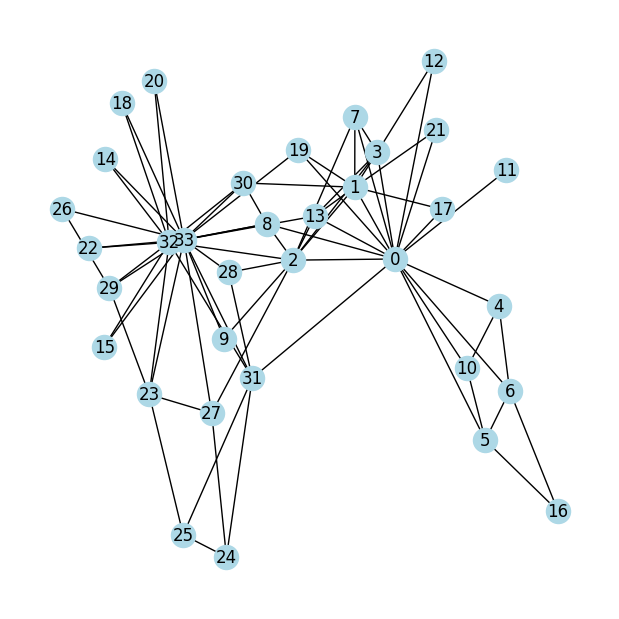

In [93]:
# AL = {
#     0: [1,3],
#     1: [0,2],
#     2: [1,3],
#     3: [0,2,4,6],
#     4: [3,5],
#     5: [4,6],
#     6: [3,5],
# }

# AL = {
#     0: [1,2,3,6],
#     1: [0,2],
#     2: [0,1],
#     3: [4,5,0,6],
#     4: [3,5],
#     5: [3,4],
#     6: [7,8,0,3],
#     7: [6,8],
#     8: [6,7]
# }

# AL = {
#     0: [1,2,3],
#     1: [0,2,3],
#     2: [0,1,3],
#     3: [0,2,4,1],
#     4: [5,7,6,3],
#     5: [4,6,7],
    # 6: [5,7,4],
#     7: [4,5,6],
# }

# AL = {
#     0: [1,5],
#     1: [0,2],
#     2: [1,3],
#     3: [2,4],
#     4: [3,5],
#     5: [4,0]
# }

# AL = nx.to_dict_of_lists(nx.davis_southern_women_graph())
AL = nx.to_dict_of_lists(nx.karate_club_graph())

# top_nodes, bottom_nodes = bipartite.sets(nx.davis_southern_women_graph())

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [94]:
L_ABS = D + A
U, S, Vt = np.linalg.svd(L_ABS)
V = Vt.T
S = np.diag(S)

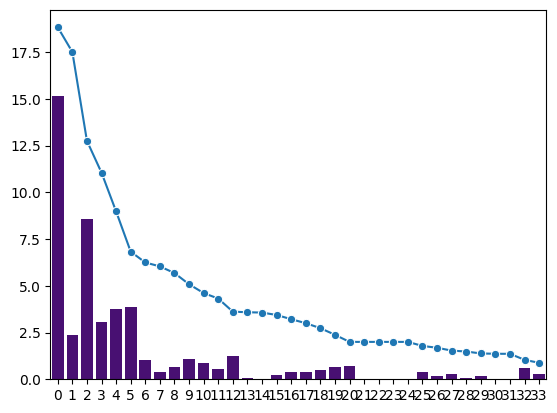

In [ ]:
svs = np.diag(S)
decrease = np.abs(np.diff(svs_normalized, prepend=svs[0]))
sns.lineplot(svs, marker='o')
sns.barplot(x=list(range(len(decrease))), y=decrease, color='indigo')
plt.show()

<Axes: >

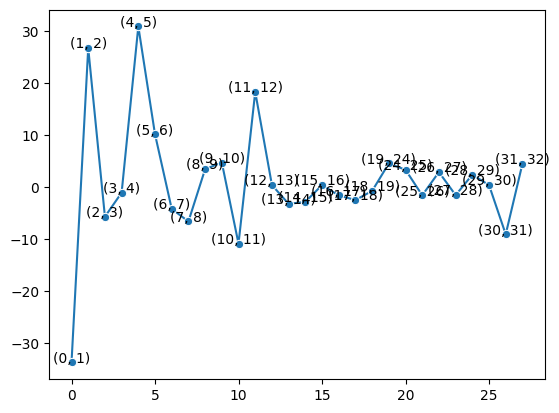

In [121]:
svs_normalized = svs / svs[0] * len(svs)
result = determine_rank_cutoff(svs / 2)
angles = result['angles']
points = result['points']
for i, value in enumerate(angles):
    plt.text(i, value, f'{points[i]}', ha='center')
sns.lineplot(angles, marker='o')

In [97]:
k = 3
U_k = U[:,0:k+1]
S_k = S[0:k+1,0:k+1]
V_k = V[:,0:k+1]

# Compute cosine matrix

In [98]:
CM = np.zeros((m,n))
vectors = S_k @ V_k.T
for i in range(0,vectors.shape[1]):
    for j in range(i+1, vectors.shape[1]):
        u = vectors[:,i]
        v = vectors[:,j]
        cosine = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
        CM[i,j] = cosine
        CM[j,i] = cosine
np.fill_diagonal(CM, 1)

# Reorder cosine matrix

In [99]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

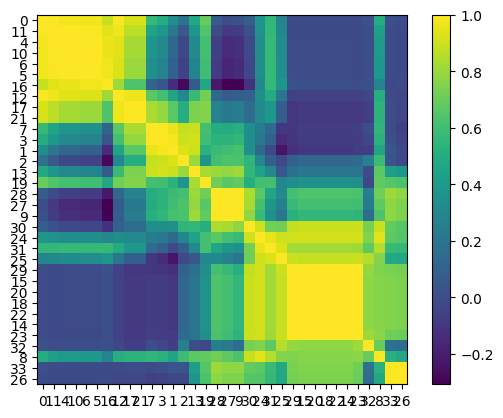

In [100]:
# print(INDEX)
# for r in range(CM_REORDERED.shape[0]):
#     line = ""
#     for c in range(CM_REORDERED.shape[1]):
#         line += str(CM_REORDERED[r,c])
#         if (c < CM_REORDERED.shape[1] - 1):
#             line += ","
#     print(line)

import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

# trying to algorithmically find the clusters

### summing square from the diagonal

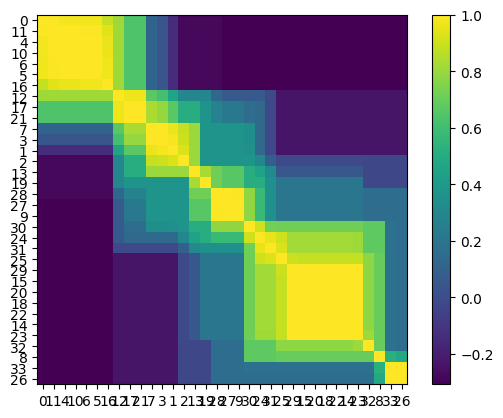

In [101]:
def to_angles(cos_matrix:np.ndarray):
    '''convert matrix of cosines to (matrix of radians) / pi'''
    return (
        np.pi - np.arccos(
            np.clip(cos_matrix, a_min=-1, a_max=1)
        )
    ) / np.pi

CM_ANGLES = to_angles(CM_REORDERED)

CM_AM = mean_from_diag(CM_REORDERED) # arithmetic means

CM_GM = np.exp(
    mean_from_diag(
        np.log(
            CM_ANGLES
        )
    )
) # geometric means

CM_HM = np.divide(1, mean_from_diag(
        np.divide(1, CM_ANGLES)
    )
) # harmonic means

test_strength = calc_from_diag(CM_REORDERED, lambda mat: np.round(np.linalg.norm(mat, ord=2), decimals = 3) / mat.shape[0])
test_bruh = calc_from_diag(CM_REORDERED, np.min)

plt.imshow(test_bruh, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

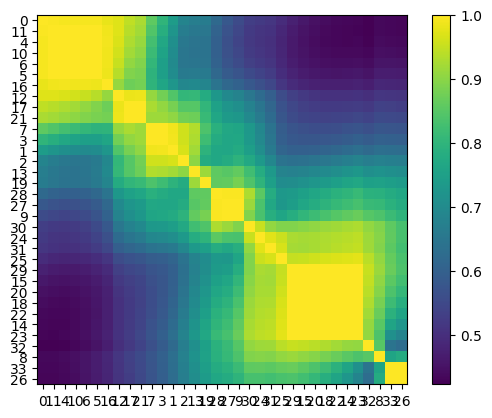

In [102]:

plt.imshow(CM_AM, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.705

/var/folders/wt/rjn2snfs5m9drm826w9lxljw0000gn/T/ipykernel_73159/2709829102.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_groups))


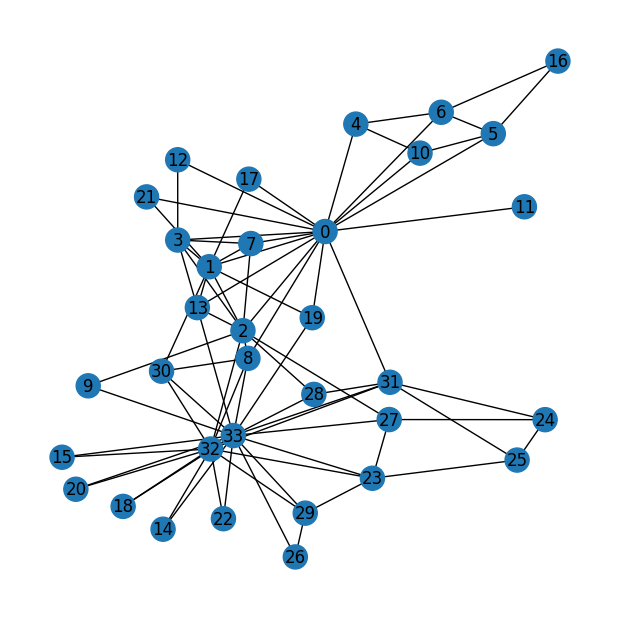

In [103]:
set_1 = [9,8,4,22]
G_2 = nx.from_numpy_array(A)
set_2 = G_2.nodes - set_1
labels = np.zeros((len(set_1) + len(set_2)))

draw_graph(A, group_labels=labels)

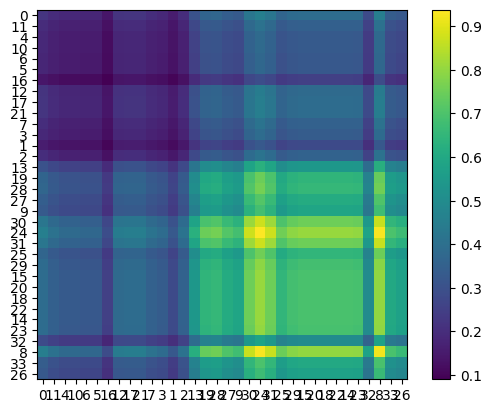

In [104]:
CMU, CMS, CMVt = np.linalg.svd(CM_REORDERED)
CMV = CMVt.T
CMS = np.diag(CMS)

s = 0 #using the 2nd singular value you can see the clusters a lot more distinctively

CMU_k = CMU[:,s:s+1]
CMS_k = CMS[s:s+1,s:s+1]
CMV_k = CMV[:,s:s+1]

disp_mat = CMU_k @ CMS_k @ CMV_k.T
plt.imshow(disp_mat, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

In [105]:
community_detection(CM_REORDERED, 0.5, sliced=False)

[(0, 12), (12, 19), (19, 34)]

In [106]:
community_strength(CM_REORDERED, 0.5)

[[ 0.00000000e+00 -8.50413461e-03 -2.30689660e-02 -2.30689660e-02
  -3.01937034e-02 -3.01937034e-02 -1.16061578e-01 -9.37127687e-03
  -7.70520317e-02 -7.70520317e-02 -4.34030576e-01 -4.96880820e-01]
 [-8.50413461e-03  0.00000000e+00 -3.63070377e-03 -3.63070377e-03
  -6.78605148e-03 -6.78605148e-03 -6.31366296e-02 -3.37571364e-02
  -1.32232174e-01 -1.32232174e-01 -5.44562275e-01 -6.11871659e-01]
 [-2.30689660e-02 -3.63070377e-03  0.00000000e+00  0.00000000e+00
  -4.90938599e-04 -4.90938599e-04 -3.67684728e-02 -5.91064302e-02
  -1.77391817e-01 -1.77391817e-01 -6.21882929e-01 -6.91721054e-01]
 [-2.30689660e-02 -3.63070377e-03  0.00000000e+00  0.00000000e+00
  -4.90938599e-04 -4.90938599e-04 -3.67684728e-02 -5.91064302e-02
  -1.77391817e-01 -1.77391817e-01 -6.21882929e-01 -6.91721054e-01]
 [-3.01937034e-02 -6.78605148e-03 -4.90938599e-04 -4.90938599e-04
   0.00000000e+00  0.00000000e+00 -2.88244264e-02 -7.01717340e-02
  -1.95560999e-01 -1.95560999e-01 -6.51005643e-01 -7.21672017e-01]
 [-3.

[-1.916, -0.667, -1.992]